Cargamos las librerías, el conjunto de datos y algunas variables que emplearemos durante el proceso:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pickle
%matplotlib inline

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

df = pickle.load(open('./processed_data/houses_cleaned.p',"rb"))

# Omitimos los warnings
import warnings
warnings.filterwarnings('ignore')

# Modelo de regresion logística

El primer modelo que implementaremos será un modelo de regresión logística, con el cual, trataremos de predecir si una vivienda cuesta más o menos que cierta cantidad. 

Así, podríamos utilizar como umbral, por ejemplo, el crédito que disponemos para comprar nuestra casa. Con lo cual, una posible aplicación de este modelo podría ser la de discernir si una casa se ajusta o no a nuestro presupuesto con tan solo indicarle las características deseadas (metros cuadrados, número de habitaciones, ubicación, ...).

## Preparación de los datos

Los modelos de regresión (tanto el logístico como el lineal), requieren que las variables sean numéricas. Por lo tanto, para poder incluir variables categóricas, tenemos que realizar un **one-hot-encoding**. En nuestro conjunto de datos tenemos las siguientes variables categóricas:

+ __<font color=#5F66A1>house_type</font>__
+ __<font color=#5F66A1>condition</font>__
+ __<font color=#5F66A1>garage</font>__
+ __<font color=#5F66A1>location</font>__
+ __<font color=#5F66A1>loc_city</font>__
+ __<font color=#5F66A1>loc_zone</font>__

En el caso de las variables relacionadas con la ubicación, en realidad las 3 hacen referencia a una sola, solo que con granularidad distinta. Por ello, optaremos por quedarnos con la más específica, __<font color=#5F66A1>location</font>__, y descartaremos el resto, para no incurrir en problemas de multicolinealidad. Con lo cual, procedemos a crear las variables *dummy*:

In [2]:
dummy_houseType = pd.get_dummies(df['house_type'])
dummy_garage = pd.get_dummies(df['garage'], prefix='garage')
dummy_condition = pd.get_dummies(df['condition'])
dummy_location = pd.get_dummies(df['location'])
dummy_houseType.head(5)

,Casa o chalet,Casa rural,Chalet adosado,Dúplex,Estudio,Finca rústica,Otros,Piso,Ático
0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0


Por cada variable hemos se han generado tantas nuevas variables como categorías distintas hubiere. Estas nuevas variables, en aquellas viviendas que sean de esa categoría toman como valor 1, y en el resto,0. Esto puede comprobarse con el ejemplo superior, donde vemos que por cada tipo de casa se ha generado una nueva variable binaria, que toma como valor 1 solo si la vivienda corresponde con su categoría.

Por otro lado, en los modelos de regresión conviene no emplear variables correlacionadas, ya que su inclusion genera multicolinealidad, lo cual es un factor de inestabilidad que ha de evitarse. Sin embargo, al crear las variables *dummy* hemos añadido cierto nivel de multiconlinealidad, ya que las variables no son independientes entre sí. Esto se percibe claramente al pensar en que no hace falta la variable **Ático** para saber cuando una vivienda es un ático. Basta con ver cuando el resto de variables tiene todas valores nulos para saber que esa vivienda es un ático.

Esta multiconlinealidad la podemos evitar fácilmente desprendiéndonos de una de las variables generadas. Por lo tanto, procedemos a descartar una columna por cada variable dummy que hemos creado. En este caso, para el ejemplo antes visto del tipo de casa, descartaremos la columna *Otros*, ya que es la menos representativa:

In [3]:
dummy_houseType = dummy_houseType.drop(columns=['Otros'])
dummy_garage = dummy_garage.drop(columns=['garage_sin garaje'])
dummy_condition = dummy_condition.drop(columns=['buen estado'])
dummy_location = dummy_location.iloc[:,1:]
dummy_houseType.head(5)

,Casa o chalet,Casa rural,Chalet adosado,Dúplex,Estudio,Finca rústica,Piso,Ático
0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0


Una vez tenemos ya nuestras variables dummy, solo nos resta añadirlas a nuestro conjunto de datos principal, a la par que nos deshacemos de todas las categóricas: 

In [4]:
df_dummy = (df
            .join([dummy_houseType, dummy_garage, dummy_condition, dummy_location])
            .drop(columns=['house_type', 'garage', 'condition', 'location', 'loc_zone', 'loc_city']))

A continuación, descartamos tanto las variables de exploración (**<font color=#5F66A1>house_id</font>** y **<font color=#5F66A1>ad_description</font>**), así como las variables que en el análisis exploratorio hemos descubierto están correlacionadas entre sí (**<font color=#5F66A1>pop_total</font>** y **<font color=#5F66A1>pop_>=65</font>**)

In [5]:
df_pred = df_dummy.drop(columns=['house_id', 'ad_description', 'pop_total', 'pop_>=65'])

Y por último generamos nuestra variable objetivo binaria, a la cual denominaremos **credit**, y que tomará como valor *True*, si nuestro crédito es superior al precio de la vivienda, y *False* en caso contrario.

Asimismo, estableceremos nuestro crédito en 230.000€:

In [6]:
credit = 230000
df_pred["credit"] = np.where(df["price"] < credit, True, False)

perc = round((100*df_pred.credit.value_counts()[True])/len(df_pred),2)
print(f'Porcentaje de datos con precio inferior al crédito: {perc}%')

Porcentaje de datos con precio inferior al crédito: 50.31%


## Implementación del modelo

### Division del conjunto de datos

El primer paso para implementar nuestro modelo, será dividir nuestro conjunto de datos en 2 subconjuntos, uno de entrenamiento, y otro de test, en una proporción de 75% y 25% respectivamente. Por otro lado, separaremos también nuestra variable dependiente (X e y):

In [7]:
X = df_pred.drop(columns='credit')
y = df_pred.credit

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.25, random_state=89, shuffle=True)

print(f'Número de datos para entrenamiento: {len(X_train)}')
print(f'Número de datos para test: {len(X_test)}')

Número de datos para entrenamiento: 15609
Número de datos para test: 5204


### Predicciones

Una vez disponemos ya de los datos debidamente preparados, procedemos a entrenar nuestro modelo logístico con el subcojunto de *train*, tras lo cual lo validaremos haciendo predicciones sobre el conjunto de *test*. Finalmente, además de comprobar la precision (*accuracy*) de nuestro modelo, visualizaremos la curva ROC.


Accuracy: 91.47 %



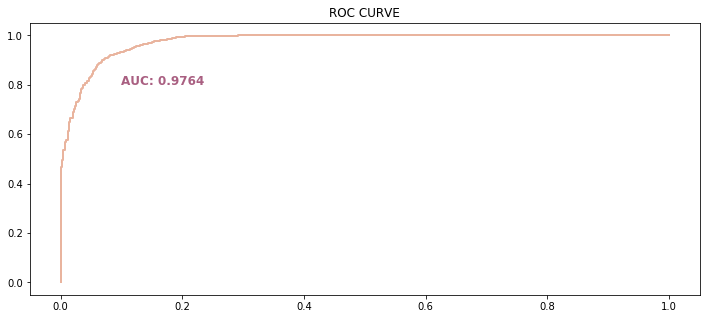

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

modelo = LogisticRegression(random_state=1)
modelo.fit(X_train, y_train)
y_pred  =  [x[1] for x in modelo.predict_proba(X_test)]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
acc = 100*round(metrics.accuracy_score(y_test, [1 if y > 0.5 else 0 for y in y_pred]),4)

print(f'\nAccuracy: {acc} %\n')

plt.figure(figsize=(12, 5))
plt.plot(fpr, tpr, linewidth=2, color='#e9b49e')
plt.title('ROC CURVE')
plt.text(0.1, 0.8, f'AUC: {round(metrics.auc(fpr, tpr),4)}'
         , size='large', color='#a95f81', weight='semibold')
plt.show()

# Modelo de regresión lineal

## XG-Boost

Para el caso del modelo de regresión lineal, nos valdremos de la técnica de potenciación del gradiente (*Gradient Boosting*), la cual sirve para generar un modelo predictivo de gran precisión mediante la suma de muchos modelos de predicción débiles (árboles de decisión).

Más concretamente, emplearemos una implementación de esta técnica llamada **XG-Boost**, *eXtreme Gradient Boosting*, ya que se ha convertido, gracias a su eficiencia y eficacia, en uno de los modelos más empleados en la actualidad para lidiar con problemas de regresión y clasificación relacionados con datos tabulares, como en este caso.

Este gran rendimiento viene dado, entre otros factores, por el amplio abaníco de hiperparámetros que contiene. Estos hiperparámetros permiten un ajuste muy minucioso y, con una buena afinación, se puede lograr optimizar y mejorar el resultado obtenido de forma considerable.

No obstante, esta afinación no es trivial, y requiere que, para conseguir buenos resultados, sea necesaria una cuidadosa estrategia de hiperparametrización.

Así, dado que gran parte de la implementación del modelo de regresión recae sobre esta búsqueda, conviene realizar una breve descripción inicial acerca de cuales son estos hiperparámetros, y de qué modo afectan a nuestro modelo:

### Hiperparámetros de XG-Boost

+ __<font color=#5F66A1>objective</font>__: 

Con este hiperparámetro especificamos qué tipo de modelo queremos construir. En nuestro caso, el modelo será el de regresión por mínimos cuadráticos ("reg:squarederror").


+ __<font color=#5F66A1>eval_metric</font>__:

Con este hiperparámetro especificamos la función de coste que tratamos de minimizar. Así, cada nuevo árbol que XG-Boost genere, tendrá por único objetivo minimizar esta función.

La función de coste que nosotros emplearemos será la raíz del error cuadrático medio (**RMSE**). Por lo tanto, cuanto menor sea el **RMSE** que obtengamos con un modelo, asumiremos que mejor es éste, ya que, en suma, los precios reales de las viviendas se ajustarán más a su hiperplano de regresión que al de otros modelos.

Si bien, para nuestro escenario *RMSE* parece ser la función de coste más apropiada, dependiendo de lo que se quisiera obtener, podría haberse optado por utilizar otra función de coste, como por ejemplo *MAE*, *LOG COSH* o *HUBER*.


+ __<font color=#5F66A1>n_estimators</font>__:

Sirve para establecer cuántos árboles queremos exactamente que se construyan. Juega un papel fundamental en el aprendizaje de nuestro modelo ya que, con cada nuevo árbol, XG-Boost tratará de minimizar la función de coste que le hayamos asignado (RMSE). Por tanto, cuanto mayor sea el número de árboles que empleemos, más estaremos minimizado nuestro error...

...no obstante, resulta necesario subrayar aquí que el error que XG-Boost minimizará será el error del conjunto de entrenamiento. Es decir, el modelo aprenderá a predecir cada vez más certeramente el precio de aquellas viviendas con las que se entrene. Pero el hecho de que aprenda a predecir cada vez mejor los precios de estas casas, no siempre conlleva que aprenda a hacer lo propio con otras viviendas. Es más, lo que sucederá es que, a partir de un cierto número de árboles, el modelo se sobrespecializará tanto (*overfitting*) en los datos de entrenamiento que ya no sabrá generalizar este conocimiento, y empezará a realizar predicciones cada vez más desacertadas. Por ello, la clave, aquí, será ajustar este hiperparámetro hasta encontrar ese punto en el cual se consigue un modelo complejo, pero que además es capaz de generalizar.


+ __<font color=#5F66A1>early_stopping</font>__:

Una buena estrategia para obtener el número de árboles adecuado es dividir el conjunto de entrenamiento en 2 nuevos subconjuntos, y usar uno para entrenar el modelo, y el otro para validarlo.

De este modo, escogiendo un número muy elevado de árboles, podremos ver que tanto el error en el conjunto de entrenamiento, como en el de validación, en ambos, va disminuyendo. Sin embargo, veremos que, llegados a un punto, pese a que el error en el conjunto entrenamiento sigue disminuyendo, el error en el conjunto de validación ya no disminuirá, y empezará a incrementar.

Ese punto de inflexión será el punto en el cual el modelo se está empezando a sobrespecializar. Por lo tanto, nos convendrá seleccionar el número de árboles justo previo a ese punto. 

Para ello, tenemos diferentes alternativas. La forma más sencilla sería la de entrenar nuestro modelo con un número muy elevado de árboles, y evaluar cuándo se ha dado el punto de inflexión a posteriori. Sin embargo, entrenar un modelo con un número muy elevado de árboles es costoso. Una forma más eficiente puede ser la de ir monitorizando la tendencia del error en el conjunto de validación, y detener la creación de árboles en cuanto se detecte que ya no decrece.

Pero, dado que el modelo no busca minimizar el error del conjunto de validación, puede ocurrir que se de un pequeño paso en falso en algún momento que haga aumentar por un momento el error, pero que no por ello hayamos llegado al punto donde empieza a generarse *overfitting*. Es más, estos pequeños pasos en falso son muy habituales a partir de cierto punto.

Con lo cual, un enfoque aún mejor que el de parar el crecimiento al primer indicio de retroceso, puede ser el de detenerse solo tras un cierto número de pasos en falso consecutivos. Y eso es para lo que sirve exactamente el hiperparámetro __early_stopping__; para controlar cuántos pasos en falso podemos dar antes de considerar que la tendencia no es reversible, y que es mejor dejar de generar más árboles, evitando de tal modo el tener que generar un ingente número de árboles en vano.


+ __<font color=#5F66A1>learning_rate</font>__:

Se ha mencionado ya en varias ocasiones que XG-Boost generará nuevos árboles, mediante los cuales, buscará de minimizar el error cuadrático medio. Sin embargo, hasta ahora no hemos hablado de la velocidad con la que XG-Boost tratará de acercarse a este mínimo. Este hiperparámetro sirve precisamente para eso, para controlar la tasa de aprendizaje con la cual un árbol nuevo trata de corregir los errores.

Cuanto mayor sea la tasa, más rápido tratará el modelo de alcanzar ese mínimo. Esto será muy beneficioso en las primeras iteraciones, ya que con pocos pasos, estaremos muy cerca ya del mínimo. Sin embargo, cerca del mínimo, cuando el ajuste necesario sea muy sutil, si los cambios son demasiado bruscos, provocará que no se pueda alcanzar exactamente el punto mínimo, sino otro más o menos cercano, dependiendo de cuán alto hayamos forzado que sea la tasa de aprendizaje.

Por otro lado, tasas más pequeñas, fuerzan que el aprendizaje sea más lento, por lo que, con cada árbol nuevo, el modelo tratará de corregir el error de forma más gradual. Esto hará que se necesite más árboles para converger, pero a su vez, permitirá que se converja de forma más precisa en el punto mínimo.

No obstante, si tomamos una tasa de aprendizaje demasiado pequeña, cabe la posibilidad que se converja, no en el mínimo global, sino en un mínimo local. Sin embargo, en la práctica no suele ser muy habitual que se converja en un mínimo local, y en general, cuanto menor sea la tasa de aprendizaje, mejores serán los resultados, siempre a costa de requerir muchísimo más tiempo para el entrenamiento del modelo.


+ __<font color=#5F66A1>max_depth</font>__:

Con este hiperparámetro restringimos la profundidad de cada árbol de decisión. Cuanto mayor sea la profundidad, más complejo será cada árbol de nuestro modelo, lo cual, si bien puede posibilitar predicciones más complicadas, también puede generar *overfitting*. 

A su vez, dado que a mayor profundidad, más complejidad, cuanto mayor sea nuestro valor de **max_depth**, menor será el número de árboles a partir del cual empezaremos a padecer un sobreentrenamiento.


+ __<font color=#5F66A1>min_child_weight</font>__:

En el caso de modelos de regresión, este hiperparámetro sirve para restringir el número de instancias de cada nodo, forzándolo a que sea siempre superior a **min_child_weight**. Es decir, si tras cierta partición del árbol, en alguno de los nodos que se han creado caen menos observaciones que las que se especifícan en el hiperparámetro, esa partición no se llevará a cabo.

Así, cuanto mayor sea su valor, más estaremos limitando la existencia de nodos muy específicos.
Y viceversa, a medida que su valor se vaya acercando a 1 (nodos sin ninguna restricción), más complejo será cada árbol, lo cual, nuevamente, si bien podría aumentar el poder predictivo del modelo, también puede generar *overfitting*.


+ __<font color=#5F66A1>subsample</font>__ & **<font color=#5F66A1>colsample_bytree</font>**: 

Con estos dos hiperparámetros restringimos el número de observaciones y variables para cada árbol. Sus valores van de 0 a 1, y reflejan el porcentaje de observaciones/columnas que se usan, donde 0 significa que no se usa ninguna observación/columna, y donde 1 significa que se usan todas.

Esta restricción sirve para forzar a que cada árbol emplee distintas variables y distintas reglas para su contrucción. Así, nuevamente, cuanto menor sea su valor, más conservadores seremos, lo cual podrá evitar un posible *overfitting* a costa de perder cierta complejidad.


+ __<font color=#5F66A1>gamma</font>__ & **<font color=#5F66A1>reg_alpha</font>**:

Ambos hiperparámetros sirven para regularizar nuestro hiperplano de regresión. Con **gamma** estableceremos el mínimo de reducción de nuestra función de coste para realizar una partición, y con **reg_alpha** estaremos añadiendo la regularización L1 (análoga a la regresión Lasso).

## Creación de funciones

A lo largo de la optimizacion de hiperparámetros, será necesario implementar y probar un gran número de modelos hasta encontrar aquel que mejores resultados nos ofrezca. Para esta tarea crearemos 4 funciones:

La primeras dos funciones nos servirán para generar una búsqueda por rejilla y para plasmar los resultados de las distintas combinaciones mediante un mapa de calor. Así, mediante ambas funciones, trataremos de encontrar la mejor combinación de hiperparámetros posible:

In [9]:
def grid_XGBRegressor(params, grid_p, X_train, y_train, cv_folds=5):
        
    gsearch = GridSearchCV(estimator = xgb.XGBRegressor(**params),
                               param_grid = grid_p,
                               scoring='neg_mean_squared_error',
                               n_jobs=8,
                               iid=False,
                               cv=cv_folds,
                               return_train_score=True,
                               verbose=True)
    
    gsearch.fit(X_train, y_train)
    
    return gsearch

In [10]:
def plot_grid_XGBRegressor(gsearch, grid_p, grid_labels):
    
    x_len = len(grid_p[grid_labels[0]])
    x_label = grid_labels[0]
    
    if(len(grid_labels)==2):
        y_len = len(grid_p[grid_labels[1]])
        y_label = grid_labels[1]
    else:
        y_len = 1
        
                
    print(f'Los mejores parametros son: {gsearch.best_params_}\n')
    
    results_gsearch = pd.DataFrame(gsearch.cv_results_)
    scores_gsearch = np.array(np.sqrt(-results_gsearch.mean_test_score)).reshape(y_len, x_len)
    plt.figure(figsize=(12, y_len))

    if(len(grid_labels)==2):
        ax = sns.heatmap(scores_gsearch, cmap="rocket_r", annot=True, 
                 xticklabels=grid_p[x_label], yticklabels=grid_p[y_label], fmt='g')
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        
    else:
        ax = sns.heatmap(scores_gsearch, cmap="rocket_r", annot=True, 
                 xticklabels=grid_p[x_label], fmt='g') 

La segunda la usaremos cuando queramos obtener un número de árboles adecuado aproximado mediante validación cruzada:

In [11]:
def get_n_estimators(params, dtrain, cv_folds=5, early_stopping_rounds=False, verbose=True):
    
    cvresult = xgb.cv(params, dtrain,               
                      num_boost_round=params['n_estimators'],
                      early_stopping_rounds=early_stopping_rounds,
                      nfold=cv_folds,
                      stratified=True,
                      metrics=params['eval_metric'],
                      seed=150,
                      verbose_eval=verbose)

    print(f'"n_estimators": {cvresult.shape[0]}')
    print(cvresult.tail(1))

Y la última la usaremos para entrenar y validar nuestro modelo final:

In [12]:
from sklearn.metrics import mean_squared_error

def xgb_fit_pred(params, dtrain, dtest, y_test):

    xgb_model = xgb.train(params, dtrain, num_boost_round=params['n_estimators'])
    y_pred = xgb_model.predict(dtest)    
    
    # Calculate eval metrics:
    residuals = y_pred - y_test
    SSD = np.sum(residuals ** 2)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # RMSE = np.sqrt(SSD/len(y_pred)-len(X_train.columns)-1)
    error = 100*rmse/np.mean(y_test)
    
    # Plot residuals
    custome_residuals_plot(residuals, y_test, rmse)
    
    # Print model report:
    print(f"RMSE: {rmse}") # RMSE: Root Mean Squared Error:
    print(f"error: {round(error,2)}%")
    
    # Price prediction accuracy
    diff = pd.DataFrame(np.where(abs(residuals) < 15000, '<±15k',
        np.where(abs(residuals) < 30000, '±15k - ±30k',
        np.where(abs(residuals) < 50000, '±30k - ±50k',
        np.where(abs(residuals) < 75000, '±50k - ±75k','>±75k')))))

    results= pd.DataFrame()
    results['total'] = diff[0].value_counts()
    results['perc'] = round(100*results['total']/len(residuals),2)
    print(results['perc'])
    
    return xgb_model

Además, definimos una quinta función para visualizar los residuos entre el precio predicho y el precio real de las viviendas de nuestro modelo final, junto con el porcentaje de viviendas que están a un margen de distancia máximo del valor RMS (raíz del error cuadrático medio):

In [13]:
def custome_residuals_plot(residuals, y_test, rmse):
    
    f, axes = plt.subplots(figsize=(12, 6))
    sns.despine(left=True) 
    sns.scatterplot(y_test, residuals, color='#f8e9e2', alpha=.4, edgecolor='#e9b49e', linewidth=0.1)

    plt.plot((0, max(y_test)), (0,0),':', color='#636261')
    plt.plot((0, max(y_test)), (rmse, rmse), '-.', linewidth=0.4, color='#636261', alpha=0.5)
    plt.plot((0, max(y_test)), (-rmse, -rmse), '-.', linewidth=0.3, color='#636261', alpha=0.5)

    x_fill = np.arange(0,  max(y_test), max(y_test)/100)
    plt.fill_between(x_fill, -rmse, rmse, color='#636261', alpha=0.05)

    plt.text(max(y_test)/30, rmse*1.4, f'+{int(rmse)} €', color='#636261', size='large')
    plt.text(max(y_test)/30, -rmse*1.8 , f'-{int(rmse)} €', color='#636261', size='large')

    perc = round(np.where(abs(residuals) < rmse, 1,0).sum()*100/len(residuals),2)
    plt.text(max(y_test)*0.8, rmse*1.4, f'{perc}%', color='#636261', size='large', weight="bold")

    plt.title('\nRESIDUALS PLOT')
    plt.tight_layout()
    plt.show()

## Preparación de los datos

Con este segundo modelo, implementaremos un modelo de regresión para tratar de predecir el precio de las viviendas. Para ello, antes de poder alimentar nuestro modelo, sera necesario adaptar nuevamente los datos de acuerdo con las necesidades del modelo.

Así, el modelo de regresión lineal requiere que las variables sean también numéricas. Por lo tanto, procedemos nuevamente a emplear **one-hot-encoding**, tal y como se hiciera en el ejemplo anterior:

No obstante, antes de satisfacer estas necesidades, realizaremos una criba preliminar de los datos que disponemos, descartando todas las viviendas con precio superior a los 400.000€:

In [14]:
df4 = df.query('price < 400000')

dummy_houseType = pd.get_dummies(df4['house_type'])
dummy_garage = pd.get_dummies(df4['garage'], prefix='garage')
dummy_condition = pd.get_dummies(df4['condition'])
dummy_location = pd.get_dummies(df4['location'])

dummy_houseType = dummy_houseType.drop(columns=['Otros'])
dummy_garage = dummy_garage.drop(columns=['garage_sin garaje'])
dummy_condition = dummy_condition.drop(columns=['buen estado'])
dummy_location = dummy_location.iloc[:,1:]

df_dummy = (df4
            .join([dummy_houseType, dummy_garage, dummy_condition, dummy_location])
            .drop(columns=['house_type', 'garage', 'condition', 'location', 'loc_zone', 'loc_city']))

df_pred = df_dummy.drop(columns=['house_id', 'ad_description', 'pop_total', 'pop_>=65'])

## Implementación del modelo de regresión con XGBoost

### Division del conjunto de datos

El primer paso para implementar nuestro modelo, será dividir nuevamente nuestro conjunto de datos en 2 subconjuntos, uno de entrenamiento, y otro de test, en una proporción de 75% y 25% respectivamente. Por otro lado, separaremos también nuestra variable dependiente (X e y):

In [15]:
df_pred.indoor = df_pred.indoor.astype('bool')
X = df_pred.drop(columns='price')
y = df_pred.price

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.25, random_state=89, shuffle=True)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

print(f'Número de datos para entrenamiento: {len(X_train)}')
print(f'Número de datos para test: {len(X_test)}')

Número de datos para entrenamiento: 13074
Número de datos para test: 4358


### Modelo preliminar (parámetros por defecto)

Tras dividir el conjunto, entrenaremos y validaremos nuestro primer modelo XG-Boost sin realizar ningún tipo de hiperparametrización, empleando aquellos asignados por defecto. Esto nos valdrá para poder compararlo con nuestro modelo final, y  comprobar así si la estrategia de afinación de los hiperparámetros ha servido para mejorar el resultado preliminar.

Para ello, estableceremos **RMSE** como la función de coste que se quiere minimizar:

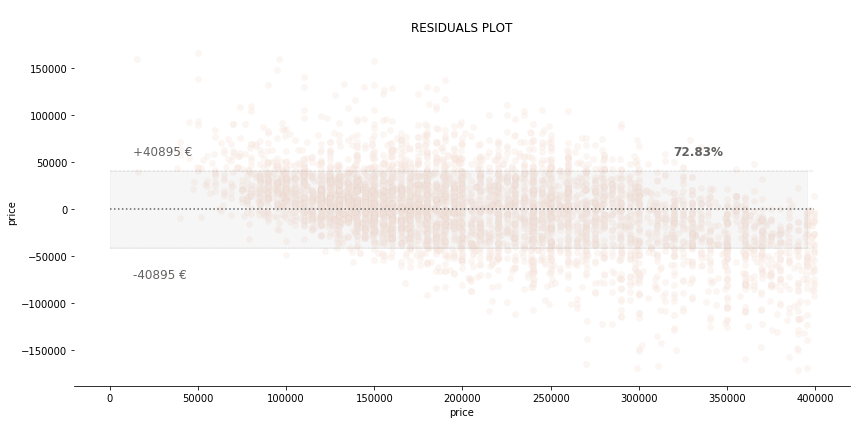

RMSE: 40895.075194110614
error: 19.14%
<±15k          34.28
±15k - ±30k    24.55
±30k - ±50k    22.07
±50k - ±75k    11.89
>±75k           7.21
Name: perc, dtype: float64


In [16]:
params = {
    'eval_metric': "rmse",
    'objective': "reg:squarederror",
    'n_estimators': 100,    
    'seed': 89,
    'nthread':8,
}

xgb_fit_pred(params, dtrain, dtest, y_test)

Vemos que el error es del 19.14%, con un 72,83% de los precios predichos dentro de un rango de +/- 40.895€ del precio real.

A partir de ahora, nuestra meta será realizar una afinación de los parámetros con la que mejorar estos resultados.

### max_depth & n_estimators

El primer paso de la hiperparametrización será hallar la mejor combinación para el número y la profundidad de los árboles. Ambos parámetros están estrechamente relacionados, dado que, por lo general, a mayor profundidad, menor será el número de árboles necesario. Por ello, emplearemos una rejilla con distintas combinaciones para así descubrir cual parece ser la mejor opción.

No obstante, empezaremos por redefinir el resto de parámetros, los cuales se mantendran constantes para cada combinación de la rejilla:

In [17]:
upd = {
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'reg_alpha': 0,
    'learning_rate': 0.1,
}
params.update(upd)

Y a continuación, empleamos la búsqueda por rejilla (*Grid Search*) con una serie de valores para los parámetros **max_depth** y **n_estimators**: 

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  8.3min
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed: 24.1min finished


Los mejores parametros son: {'max_depth': 8, 'n_estimators': 600}



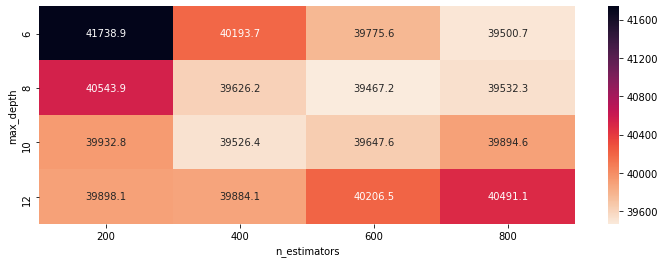

In [19]:
grid_p = {
 'n_estimators': [200,400,600,800],
 'max_depth': [6,8,10,12],
}
grid_labels = ['n_estimators','max_depth']

gsearch = grid_XGBRegressor(params, grid_p, X_train, y_train)
plot_grid_XGBRegressor(gsearch, grid_p, grid_labels)

Vemos que la mejor opción parece ser aquella que emplea 600 árboles con 6 niveles de profundidad. Por lo tanto, ajustemos la rejilla a este punto, y exploremos las combinaciones colindantes:

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 10.4min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed: 32.8min finished


Los mejores parametros son: {'max_depth': 8, 'n_estimators': 550}



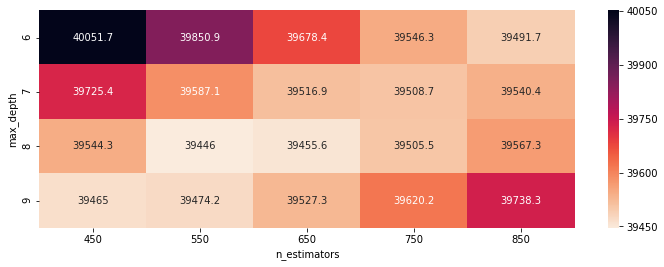

In [20]:
grid_p = {
 'n_estimators': [450,550,650,750,850],
 'max_depth': [6,7,8,9],
}
grid_labels = ['n_estimators','max_depth']

gsearch = grid_XGBRegressor(params, grid_p, X_train, y_train)
plot_grid_XGBRegressor(gsearch, grid_p, grid_labels)

La mejor combinación es **n_estimators**=550 y **max_depth**=8. Por lo tanto, actualizamos nuestros parámetros con estos nuevos valores:

In [21]:
upd = {
    'n_estimators': 550,
    'max_depth': 8
}
params.update(upd)

### min_child_weight

A continuación, trataremos de encontrar el valor de **min_child_weight** que mejores resultados parezca ofrecer. Para ello, nuevamente, emplearemos una búsqueda por rejilla:

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:  7.5min finished


Los mejores parametros son: {'min_child_weight': 1}



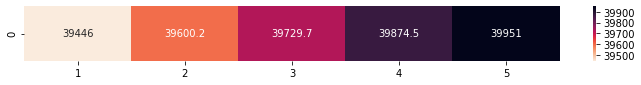

In [22]:
grid_p = {
 'min_child_weight': [1,2,3,4,5],
}
grid_labels = ['min_child_weight']

gsearch = grid_XGBRegressor(params, grid_p, X_train, y_train)
plot_grid_XGBRegressor(gsearch, grid_p, grid_labels)

Vemos que el mejor valor para **min_child_weight** es el que ya teníamos, con lo cual, lo dejamos tal y como está.

### subsample & colsample_bytree

El próximo paso de nuestra hiperparametrización es la búsqueda de los mejores valores tanto para **subsample** como para **colsample_bytree**. Para ello, una vez más, nos valdremos de la búsqueda por rejilla:

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  5.0min
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed: 16.8min finished


Los mejores parametros son: {'colsample_bytree': 0.6, 'subsample': 0.8}



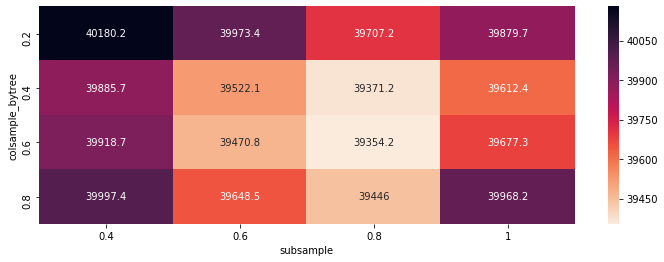

In [23]:
grid_p = {
    'subsample': [0.4,0.6,0.8,1],
    'colsample_bytree': [0.2,0.4,0.6,0.8]
}
grid_labels = ['subsample','colsample_bytree']

gsearch = grid_XGBRegressor(params, grid_p, X_train, y_train)
plot_grid_XGBRegressor(gsearch, grid_p, grid_labels)

Volvemos a generar otra rejilla para acotar más los valores:

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  6.3min
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed: 28.4min finished


Los mejores parametros son: {'colsample_bytree': 0.5, 'subsample': 0.8}



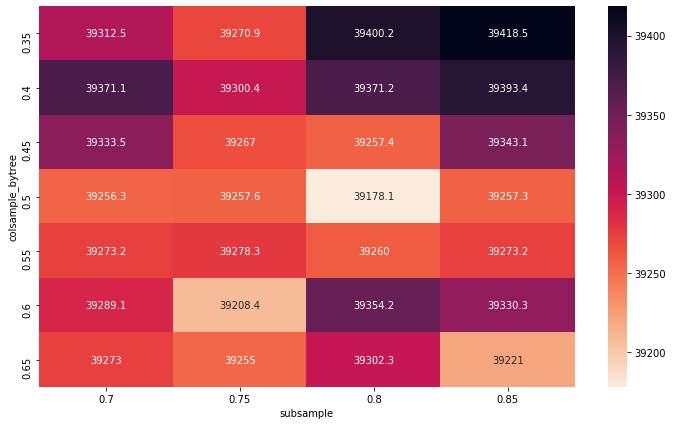

In [24]:
grid_p = {
    'subsample': [0.7,0.75,0.8,0.85],
    'colsample_bytree': [0.35,0.4,0.45,0.5,0.55,0.6,0.65]
}
grid_labels = ['subsample','colsample_bytree']

gsearch = grid_XGBRegressor(params, grid_p, X_train, y_train)
plot_grid_XGBRegressor(gsearch, grid_p, grid_labels)

Volvemos nuevamente a generar otra rejilla para afinar por última vez en la búsqueda:

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  45 out of  45 | elapsed:  8.6min finished


Los mejores parametros son: {'colsample_bytree': 0.5, 'subsample': 0.8}



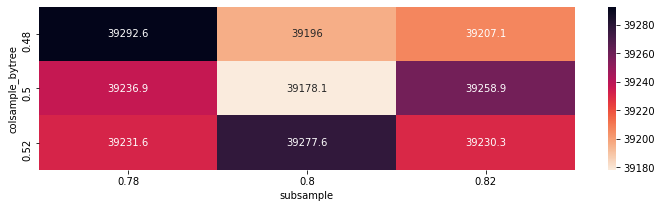

In [25]:
grid_p = {
    'subsample': [0.78,0.80,0.82],
    'colsample_bytree': [0.48,0.5,0.52]
}
grid_labels = ['subsample','colsample_bytree']

gsearch = grid_XGBRegressor(params, grid_p, X_train, y_train)
plot_grid_XGBRegressor(gsearch, grid_p, grid_labels)

Vemos que los valores no varían, por lo que actualizamos los parámetros:

In [26]:
upd = {
    'subsample': 0.8,
    'colsample_bytree':0.5,
}
params.update(upd)

### gamma & reg_alpha

Tras haber definido tanto el número como la profundidad y características de los árboles, así como el porcentaje de datos y columnas que emplearemos para cada uno de estos árboles, el siguiente paso es ajustar los parámetros de regularización.

Para ello, nuevamente, nos valdremos de la búsqueda de rejilla para hallar, primero los mejores valores para **gamma**, y luego para  **reg_alpha**:

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:  7.7min finished


Los mejores parametros son: {'gamma': 0}



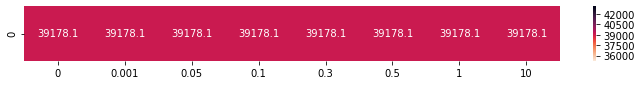

In [27]:
grid_p = {
 'gamma': [0,1e-3,0.05,0.1,0.3,0.5,1,10],
}
grid_labels = ['gamma']

gsearch = grid_XGBRegressor(params, grid_p, X_train, y_train)
plot_grid_XGBRegressor(gsearch, grid_p, grid_labels)

A continuación, hacemos lo propio con **reg_alpha**:

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:  7.6min finished


Los mejores parametros son: {'reg_alpha': 0}



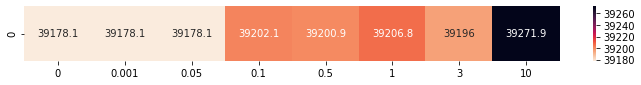

In [28]:
grid_p = {
 'reg_alpha': [0,1e-3,0.05,0.1,0.5,1,3,10],
}
grid_labels = ['reg_alpha']

gsearch = grid_XGBRegressor(params, grid_p, X_train, y_train)
plot_grid_XGBRegressor(gsearch, grid_p, grid_labels)

Vemos que la regularización no aporta ninguna mejora en este caso, por lo que dejamos ambos hiperparámetros tal y como están, con valores nulos.

### learning_rate & n_estimators

Una vez hemos seleccionado los valores para los distintos parámetros, el último paso será disminuir el valor de **learning_rate**, con lo cual, conseguiremos una afinación más precisa que, previsiblemente, haga que las predicciones sean más certeras.

No obstante, el escoger un **learning_rate** inferior acarreará que tengamos que escoger un nuevo número de árboles, ya que de mantener el que teníamos hasta ahora, no acabaría de convergería lo suficiente (necesitará muchos más).

Por otro lado, cabe recordar que los hiperparámetros que hemos ido seleccionando no son del todo independientes. Por lo tanto, el seleccionar nuevos valores tanto para **learning rate** como para **n_estimators**, probablemente, genere que la selección que hemos llevado a cabo en los pasos previos, si bien seguirá siendo buena, quizás ya no sea los óptima. Sin embargo, la búsqueda de hiperparámetros con un nivel tan bajo de **learning_rate** hubiera supuesto tiempos de entrenamiento demasiado elevados:

Por lo tanto, nos limitaremos a mantener los parámetros seleccionados en los pasos previos, excepto el número de árboles, que lo actualizaremos valíendonos de **early_stopping_rounds**: 

In [29]:
upd = {
    'learning_rate': 0.01,
    'n_estimators': 20000,
}
params.update(upd)

get_n_estimators(params, dtrain, verbose=False, early_stopping_rounds=150, cv_folds=5)

"n_estimators": 6896
      train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
6895     20048.288281      159.650768    38269.717969     651.639691


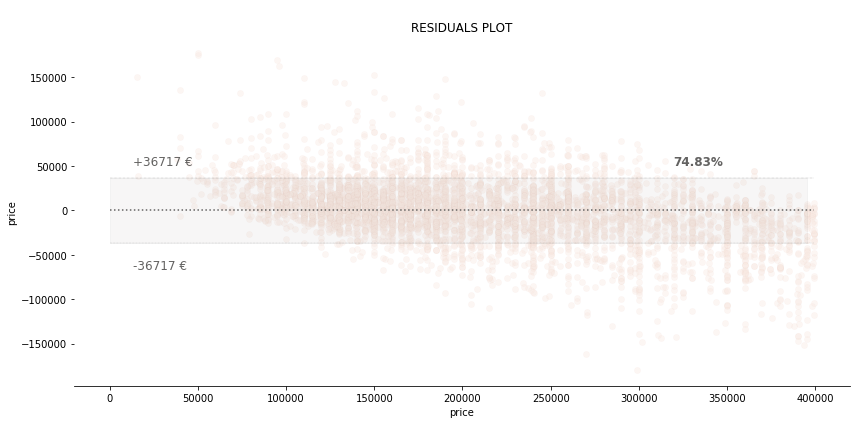

RMSE: 36717.430384167776
error: 17.18%
<±15k          41.44
±15k - ±30k    25.72
±30k - ±50k    18.17
±50k - ±75k     9.13
>±75k           5.53
Name: perc, dtype: float64


In [40]:
upd = {
    'n_estimators': 7000
}
params.update(upd)

xgb_model = xgb_fit_pred(params, dtrain, dtest, y_test)

Por último, podemos comprobar cuáles son las variables mas importantes a la hora de predecir los precios de las viviendas, utilizando para ello los **F-Score**:

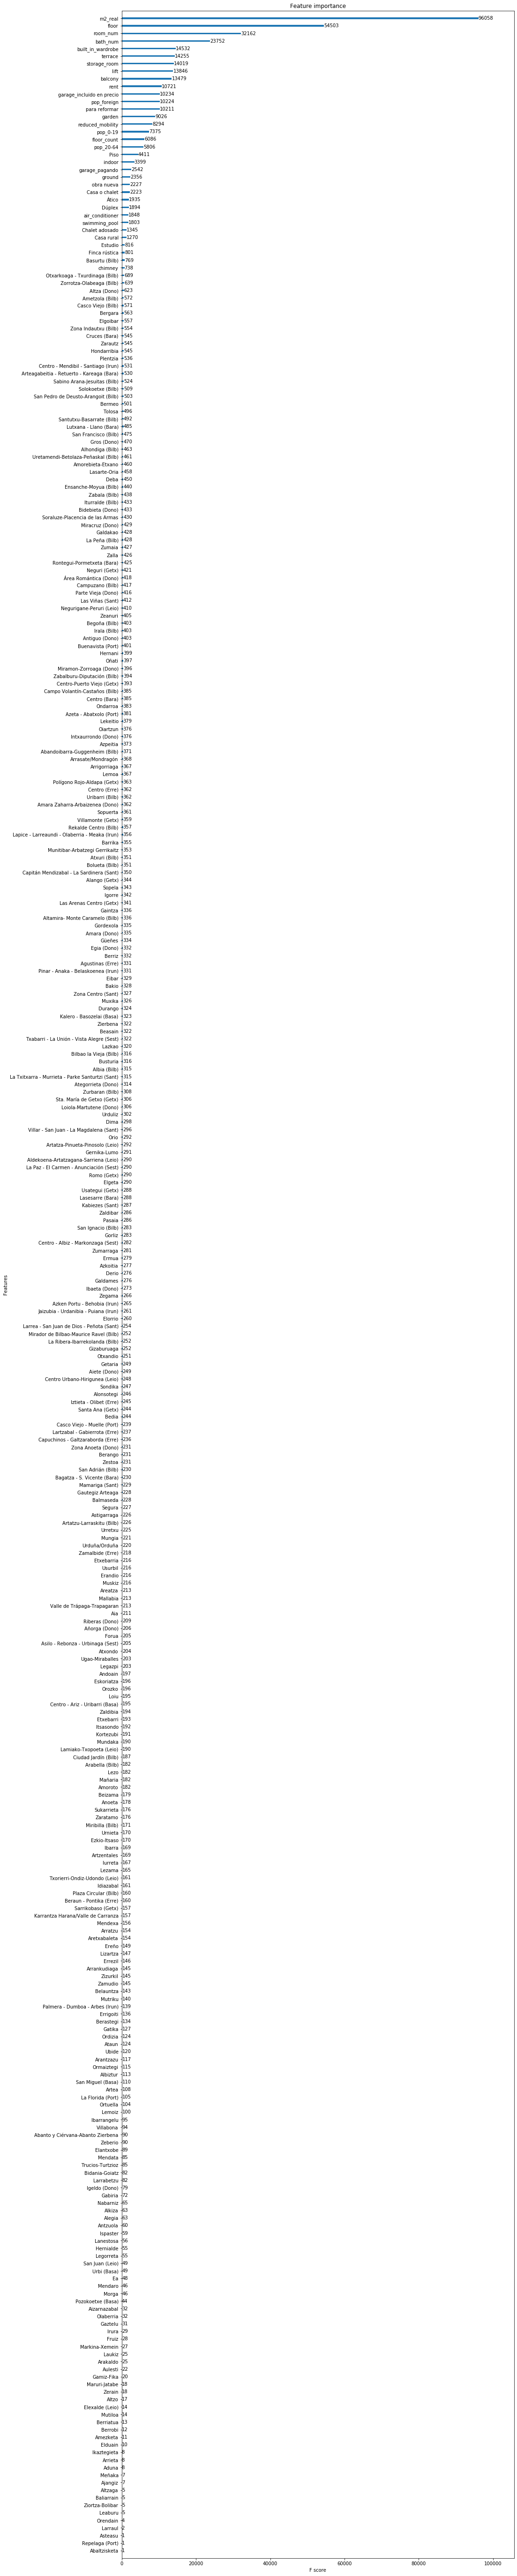

In [31]:
f, ax = plt.subplots(figsize=(15,100))

xgb.plot_importance(xgb_model, grid=False, ax=ax);

In [37]:
plt.figure(figsize=(14, 10))
x_points=np.arange(1,4001,1)

#sns.lineplot(x=x_points, y=cvresult['test-rmse-mean'], color='r');
#sns.lineplot(x=x_points, y=cvresult['train-rmse-mean']);

<Figure size 1008x720 with 0 Axes>